In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python


### Kütüphane Kurulumu

In [0]:
!pip install -q keras

### Model Ağırlıklarının BUlunduğu Dosyayı Görüntüleme

In [5]:
!ls 'drive/DLTR_COLAB/DuyguTanima/data/emotion_models/'

fer2013_mini_XCEPTION.110-0.65.hdf5


### Tanımalamalar

In [0]:
import sys
sys.path.insert(0, 'drive/DLTR_COLAB/DuyguTanima/')

In [7]:
import sys

import cv2
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.inference import load_image
from utils.preprocessor import preprocess_input

Using TensorFlow backend.


Eğitilmiş Model Ağırlıklarının Yüklenmesi

In [0]:
root = 'drive/DLTR_COLAB/DuyguTanima/'

# parameters for loading data and images
#image_path = root + 'images/test8.jpg'

detection_model_path = root + 'data/detection_models/haarcascade_frontalface_default.xml'
emotion_model_path = root + 'data/emotion_models//fer2013_mini_XCEPTION.110-0.65.hdf5'
gender_model_path = root + 'data/gender_models/simple_CNN.81-0.96.hdf5'
emotion_labels = get_labels('fer2013')
gender_labels = get_labels('imdb')
font = cv2.FONT_HERSHEY_SIMPLEX

# hyper-parameters for bounding boxes shape
gender_offsets = (30, 60)
gender_offsets = (10, 10)
emotion_offsets = (20, 40)
emotion_offsets = (0, 0)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
gender_classifier = load_model(gender_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]
gender_target_size = gender_classifier.input_shape[1:3]


### Test Klasörü Görüntüleme

In [9]:
!ls 'drive/DLTR_COLAB/DuyguTanima/images/'

bb1.jpg		   kate1.jpg  monalisa.png	    test4.jpg
bb2.jpg		   kate2.jpg  pablo.png		    test5.jpg
brando.png	   kate3.jpg  _predicted_image.jpg  test6.jpg
hababam.jpg	   lotr1.png  robertdeniro.jpg	    test.jpg
jackman.png	   lotr2.jpg  test2.jpg
jacknicholson.jpg  lotr3.jpg  test3.jpg


## Model Test

Predicted! OK!


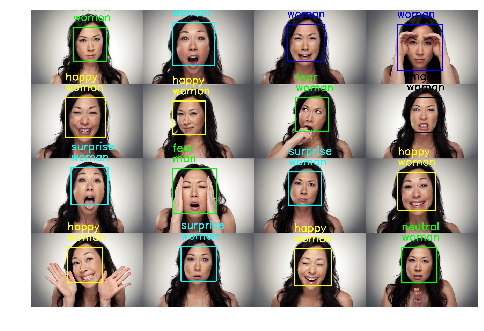

In [13]:
# parameters for loading data and images
image_path = root + 'images/test.jpg'

# loading images
rgb_image = load_image(image_path, grayscale=False)
gray_image = load_image(image_path, grayscale=True)
gray_image = np.squeeze(gray_image)
gray_image = gray_image.astype('uint8')


faces = detect_faces(face_detection, gray_image)
for face_coordinates in faces:
    x1, x2, y1, y2 = apply_offsets(face_coordinates, gender_offsets)
    rgb_face = rgb_image[y1:y2, x1:x2]

    x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
    gray_face = gray_image[y1:y2, x1:x2]

    try:
        rgb_face = cv2.resize(rgb_face, (gender_target_size))
        gray_face = cv2.resize(gray_face, (emotion_target_size))
    except:
        continue

    rgb_face = preprocess_input(rgb_face, False)
    rgb_face = np.expand_dims(rgb_face, 0)
    gender_prediction = gender_classifier.predict(rgb_face)
    gender_label_arg = np.argmax(gender_prediction)
    gender_text = gender_labels[gender_label_arg]

    gray_face = preprocess_input(gray_face, True)
    gray_face = np.expand_dims(gray_face, 0)
    gray_face = np.expand_dims(gray_face, -1)
    emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
    emotion_text = emotion_labels[emotion_label_arg]


    if emotion_text == 'angry':
        color = emotion_label_arg * np.asarray((255, 0, 0))
    elif emotion_text == 'sad':
        color = emotion_label_arg * np.asarray((0, 0, 255))
    elif emotion_text == 'happy':
        color = emotion_label_arg * np.asarray((255, 255, 0))
    elif emotion_text == 'surprise':
        color = emotion_label_arg * np.asarray((0, 255, 255))
    else:
        color = emotion_label_arg * np.asarray((0, 255, 0))

    color = color.astype(int)
    color = color.tolist()

    #if gender_text == gender_labels[0]:
    #    color = (0, 0, 255)
    #else:
    #    color = (255, 0, 0)
    

    draw_bounding_box(face_coordinates, rgb_image, color)
    draw_text(face_coordinates, rgb_image, gender_text, color, 0, -20, 1, 2)
    draw_text(face_coordinates, rgb_image, emotion_text, color, 0, -50, 1, 2)

bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
cv2.imwrite(root + 'images/_predicted_image.jpg', bgr_image)

print("Predicted! OK!")

predicted_image = image.load_img(root + 'images/_predicted_image.jpg')

plt.axis('off')
plt.imshow(predicted_image)
plt.show()


In [0]:
!kill 9 -1